# 🧪 Custom Stacking Classification

In this notebook, we implement a stacking ensemble classifier **from scratch** using base classifiers and a meta-model. We then compare the performance of these implementations with **scikit-learn**'s `StackingClassifier` model.

### ⚙️ Importing Libraries & Environment Setup

In [ ]:
from copy import deepcopy
from math import ceil
from typing import Any

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from numpy.typing import NDArray
from sklearn.datasets import make_classification
from sklearn.ensemble import (
    RandomForestClassifier,
    StackingClassifier,
)
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
    roc_auc_score,
)
from sklearn.model_selection import KFold, train_test_split
from sklearn.tree import DecisionTreeClassifier

In [207]:
%matplotlib inline

pd.set_option("display.width", 150)
pd.set_option("display.max_rows", 100)
pd.set_option("display.max_columns", None)

### 🧰 Utility Functions

In [208]:
def evaluate_classification_models(
    predictions: dict[str, NDArray[np.float64]], y: NDArray[np.float64]
) -> pd.DataFrame:
    """Evaluate multiple classification model predictions on the provided dataset.

    Args:
        predictions (dict[str, NDArray[np.float64]]): Dictionary mapping model names
            to predicted target arrays (binary or probabilities) for the dataset.
        y (NDArray[np.float64]): True binary target values of shape (n_samples,).

    Returns:
        pd.DataFrame: DataFrame containing classification metrics — Accuracy, Precision,
            Recall, F1-score, and ROC AUC — for each model. Columns correspond to
            model names, rows correspond to the metric names.
    """
    evaluations = pd.DataFrame(
        columns=predictions.keys(),
        index=["Accuracy", "Precision", "Recall", "F1-score", "ROC AUC"],
    )

    for name, y_pred in predictions.items():
        accuracy = accuracy_score(y, y_pred)
        precision = precision_score(y, y_pred)
        recall = recall_score(y, y_pred)
        f1 = f1_score(y, y_pred)
        roc_auc = roc_auc_score(y, y_pred)

        evaluations.loc[:, name] = [accuracy, precision, recall, f1, roc_auc]

    return evaluations.astype(float)

In [209]:
def plot_confusion_matrices(
    predictions: dict[str, NDArray[np.int64]],
    y_true: NDArray[np.int64],
    n_cols: int = 2,
) -> None:
    """Plot confusion matrices for multiple classification models.

    Each confusion matrix compares the true labels to predictions from one model.
    The plots are arranged in a grid layout for easy comparison.

    Args:
        predictions (dict[str, NDArray[np.int64]]): A dictionary mapping model names to
            their predicted labels (1D array of shape (n_samples,)).
        y_true (NDArray[np.int64]): True class labels (1D array of shape (n_samples,)).
        n_cols (int, optional): Number of columns in the subplot grid layout.
            Default is 2.
    """
    n_models = len(predictions)
    n_cols = min(n_models, n_cols)
    n_rows = ceil(n_models / n_cols)
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(6 * n_cols, 5 * n_rows))
    axes = np.array(axes).reshape(-1)

    for ax, (name, y_pred) in zip(axes, predictions.items(), strict=False):
        conf_matrix = confusion_matrix(y_true, y_pred)
        sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False, ax=ax)
        ax.set_xlabel("Predicted Labels")
        ax.set_ylabel("True Labels")
        ax.set_title(name)

    for i in range(n_models, len(axes)):
        fig.delaxes(axes[i])

    plt.tight_layout()
    plt.show()

### 📥 Loading the Dataset

In [210]:
# Generate dataset
X, y = make_classification(
    n_samples=1000,
    n_features=5,
    n_informative=2,
    n_classes=2,
    n_redundant=0,
    random_state=42,
)

In [211]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

### 🧠 Implementing Custom Model Algorithms

In [212]:
class MyStackingClassifier:
    """Stacking ensemble classifier.

    Combines multiple base estimators by training them on the original dataset,
    then uses their out-of-fold predictions as input features for a final estimator.
    This approach leverages the strengths of diverse models and often improves
    predictive performance.

    Attributes:
        estimators (list[tuple[str, Any]]): List of (name, estimator) tuples as
            base models.
        final_estimator (Any): The meta-estimator that aggregates base estimators'
            predictions.
        cv (int): Number of folds for cross-validation used to generate out-of-fold
            predictions.
        random_state (int): Seed for reproducibility.
        base_estimators_ (list[Any] | None): Fitted clones of the base estimators.
        final_estimator_ (Any | None): Fitted final meta-estimator.
    """

    def __init__(
        self,
        estimators: list[tuple[str, Any]],
        final_estimator: Any,
        cv: int = 5,
        random_state: int = 42,
    ) -> None:
        """Initialize the stacking classifier.

        Args:
            estimators (list[tuple[str, Any]]): Base estimators as (name, estimator)
                pairs.
            final_estimator (Any): Meta-estimator to combine base predictions.
            cv (int, optional): Number of cross-validation folds for out-of-fold
                predictions. Defaults to 5.
            random_state (int, optional): Seed for random number generation.
                Defaults to 42.
        """
        self.estimators = estimators
        self.final_estimator = final_estimator
        self.cv = cv
        self.random_state = random_state

        self.base_estimators_: list[Any] | None = None
        self.final_estimator_: Any = None

    def fit(self, X: NDArray[np.float64], y: NDArray[np.int64]) -> None:
        """Fit the stacking classifier.

        Trains base estimators using cross-validation to generate out-of-fold
        predictions which are then used as features to train the final meta-estimator.

        Args:
            X (NDArray[np.float64]): Training input data, shape (n_samples, n_features).
            y (NDArray[np.int64]): Target labels, shape (n_samples,).
        """
        self.base_estimators_ = [deepcopy(est[1]) for est in self.estimators]
        self.final_estimator_ = deepcopy(self.final_estimator)

        n_samples = X.shape[0]
        n_estimators = len(self.base_estimators_)
        meta_features = np.zeros((n_samples, n_estimators))

        kf = KFold(n_splits=self.cv, shuffle=True, random_state=self.random_state)

        for i, estimator in enumerate(self.base_estimators_):
            oof_preds = np.zeros(n_samples)
            for train_idx, valid_idx in kf.split(X):
                estimator.fit(X[train_idx], y[train_idx])
                oof_preds[valid_idx] = estimator.predict(X[valid_idx])
            meta_features[:, i] = oof_preds

            estimator.fit(X, y)

        self.final_estimator_.fit(meta_features, y)

    def predict(self, X: NDArray[np.float64]) -> NDArray[np.int64]:
        """Predict class labels for samples in X.

        Args:
            X (NDArray[np.float64]): Input data of shape (n_samples, n_features).

        Returns:
            NDArray[np.int64]: Predicted class labels.
        """
        meta_features = np.column_stack(
            [est.predict(X) for est in self.base_estimators_]
        )
        return self.final_estimator_.predict(meta_features)

### 🏋️‍♂️ Model Training

In [ ]:
# Base models
base_estimators = [
    ("dt", DecisionTreeClassifier(max_depth=3, random_state=42)),
    ("rf", RandomForestClassifier(max_depth=3, random_state=42)),
]

final_estimator = LogisticRegression(random_state=42)

# Scikit-learn stacking classifier model
sklearn_model = StackingClassifier(
    estimators=base_estimators, final_estimator=final_estimator
)
sklearn_model.fit(X_train, y_train)

# My stacking classifier model
model = MyStackingClassifier(
    estimators=base_estimators, final_estimator=final_estimator
)
model.fit(X_train, y_train)

### 📊 Comparing Algorithm Versions

In [ ]:
predictions = {
    "sklearn": sklearn_model.predict(X_test),
    "my": model.predict(X_test),
}

In [215]:
evaluate_classification_models(predictions, y_test)

,sklearn,my
Accuracy,0.850000,0.850000
Precision,0.833333,0.820755
Recall,0.867347,0.887755
F1-score,0.850000,0.852941
ROC AUC,0.850340,0.850740


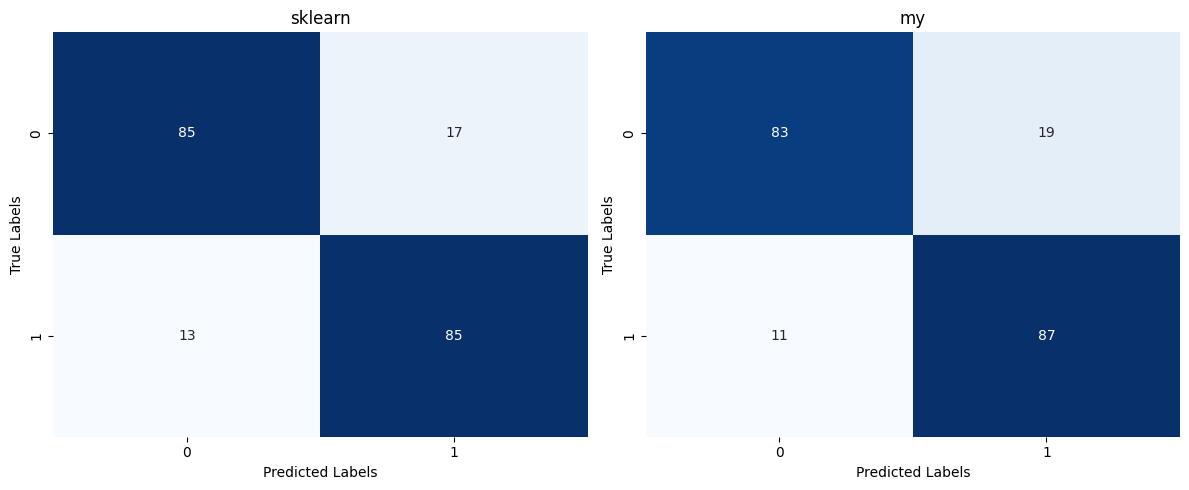

In [216]:
plot_confusion_matrices(predictions, y_test)